# 프로젝트 : 한국어 데이터로 챗봇 만들기

영어로 만들었던 챗봇을 한국어 데이터로 바꿔서 훈련시켜봅시다.

### 목차

#### Step 1. 데이터 수집하기  

#### Step 2. 데이터 전처리하기  

#### Step 3. SubwordTextEncoder 사용하기  

#### Step 4. 모델 구성하기  

#### Step 5. 모델 평가하기  

#### Step 6. 루브릭 & 회고

## Step 1. 데이터 수집하기
---
한국어 챗봇 데이터는 송영숙님이 공개한 챗봇 데이터를 사용합니다.

이 데이터는 아래의 링크에서 다운로드할 수 있습니다.

- songys/Chatbot_data (https://github.com/songys/Chatbot_data/blob/master/ChatbotData.csv)

Cloud shell에서 아래 명령어를 입력해 주세요.

- mkdir -p ~/aiffel/transformer_chatbot/data/
- ln -s ~/data/* ~/aiffel/transformer_chatbot/data/

In [135]:
# 필요한 라이브러리 import
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import numpy as np
import matplotlib.pyplot as plt

### 1.1 Data Load
---

In [136]:
os.getenv('HOME')

'/aiffel'

In [137]:
dir_path = '/aiffel/aiffel/transformer_chatbot/data'
path_to_dataset = os.path.join(dir_path, 'ChatbotData .csv')
print(dir_path)

/aiffel/aiffel/transformer_chatbot/data


In [138]:
import pandas as pd

In [139]:
data = pd.read_csv(path_to_dataset)

- 불러온 데이터를 읽어봅니다.

In [140]:
data.head()

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


- label 은 Transformer 를 진행하는데, 필요 없는 항목이므로 지워줍니다.

In [141]:
del data['label']
data.head()

,Q,A
0,12시 땡!,하루가 또 가네요.
1,1지망 학교 떨어졌어,위로해 드립니다.
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.
4,PPL 심하네,눈살이 찌푸려지죠.


- 불러온 데이터의 shape 을 확인해봅니다.

In [142]:
data.shape

(11823, 2)

## Step 2. 데이터 전처리하기
---
영어 데이터와는 전혀 다른 데이터인 만큼 영어 데이터에 사용했던 전처리와 일부 동일한 전처리도 필요하겠지만 전체적으로는 다른 전처리를 수행해야 할 수도 있습니다.

In [143]:
# 전처리 함수
def preprocess_sentence(sentence):
  # 단어와 구두점(punctuation) 사이의 거리를 만듭니다.
  # 예를 들어서 "I am a student." => "I am a student ."와 같이
  # student와 온점 사이에 거리를 만듭니다.
  sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
  sentence = re.sub(r'[" "]+', " ", sentence)

  sentence = sentence.strip()
  return sentence

In [144]:
preprocess_sentence("한글 자연어 처리의 길은 나에겐 너무 멀고 험한 듯 하다 ... ")

'한글 자연어 처리의 길은 나에겐 너무 멀고 험한 듯 하다 . . .'

In [145]:
def preprocess(question, answer):
    quest = []
    ans = []
    for s in question:
        quest.append(preprocess_sentence(s))

    for s in answer:
        ans.append(preprocess_sentence(s))

    return quest, ans

In [146]:
# 데이터를 로드하고 전처리하여 질문을 questions, 답변을 answers에 저장합니다.
questions, answers = preprocess(data['Q'], data['A'])
print('전체 샘플 수 :', len(questions))
print('전체 샘플 수 :', len(answers))

전체 샘플 수 : 11823
전체 샘플 수 : 11823


질문과 답변은 병렬적으로 구성되는 데이터셋이므로 두 샘플 수는 정확하게 일치해야 합니다.

둘 다 11823 개의 샘플이 저장되었습니다.

임의로 22번째 샘플(인덱스 상으로는 21번 샘플)을 출력해서 질문과 답변이 병렬적으로 잘 저장은 되었는지, 그리고 전처리 함수에서 의도했던 전처리가 진행되었는지 확인해 봅시다!

In [147]:
print('전처리 후의 22번째 질문 샘플: {}'.format(questions[21]))
print('전처리 후의 22번째 답변 샘플: {}'.format(answers[21]))

전처리 후의 22번째 질문 샘플: 가스비 장난 아님
전처리 후의 22번째 답변 샘플: 다음 달에는 더 절약해봐요 .


?나 .과 같은 구두점들이 단어들과 분리되어 단어와 구두점 사이에는 공백이 추가된 것을 확인할 수 있습니다. 이렇게 함으로써 단어를 토크나이징 하는 과정에서 구두점과 붙어있던 단어들을 하나의 단어로 인식하는 것을 방지할 수 있습니다.

## Step 3. SubwordTextEncoder 사용하기
---
한국어 데이터는 형태소 분석기를 사용하여 토크나이징을 해야 한다고 많은 분이 알고 있습니다. 하지만 여기서는 형태소 분석기가 아닌 위 실습에서 사용했던 내부 단어 토크나이저인 SubwordTextEncoder를 그대로 사용해보세요.

### 3-1. 단어장 만들기
---
우선 각 단어에 고유한 정수 인덱스를 부여하기 위해서 단어장(Vocabulary)을 만들어보겠습니다.

단어장을 만들 때는 질문과 답변 데이터셋을 모두 사용하여 만듭니다.

In [148]:
import tensorflow_datasets as tfds
print("살짝 오래 걸릴 수 있어요. 스트레칭 한 번 해볼까요? 👐")

# 질문과 답변 데이터셋에 대해서 Vocabulary 생성. (Tensorflow 2.3.0 이상) (클라우드는 2.4 입니다)
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)
print("슝=3 ")

살짝 오래 걸릴 수 있어요. 스트레칭 한 번 해볼까요? 👐
슝=3 


In [149]:
# 시작 토큰과 종료 토큰에 고유한 정수를 부여합니다.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]
print("슝=3")

슝=3


시작 토큰과 종료 토큰에 부여된 정수를 출력해봅시다.

In [150]:
print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])

START_TOKEN의 번호 : [8173]
END_TOKEN의 번호 : [8174]


각각 8,173과 8,174라는 점에서 현재 단어장의 크기가 8,173(0번부터 8,330번)이라는 의미입니다.

두 개의 토큰을 추가해 주었기 때문에 단어장의 크기도 +2임을 명시해 주어야 합니다.

In [151]:
# 시작 토큰과 종료 토큰을 고려하여 +2를 하여 단어장의 크기를 산정합니다.
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

8175


### 3-2. 각 단어를 고유한 정수로 인코딩(Integer encoding) & 패딩(Padding)
---
위에서 tensorflow_datasets의 SubwordTextEncoder를 사용해서 tokenizer를 정의하고 Vocabulary를 만들었다면, tokenizer.encode()로 각 단어를 정수로 변환할 수 있고 또는 tokenizer.decode()를 통해 정수 시퀀스를 단어 시퀀스로 변환할 수 있습니다.

예를 들어서 22번째 샘플을 tokenizer.encode()의 입력으로 사용해서 변환 결과를 봅시다.

In [152]:
# 22번째 문장에 대해서 인코딩 & 패딩 테스트
print("정수 인코딩 후 21번째 질문 샘플 : {}".format(tokenizer.encode(questions[21])))
print("정수 인코딩 후 21번째 답변 샘플 : {}".format(tokenizer.encode(answers[21])))

정수 인코딩 후 21번째 질문 샘플 : [5764, 610, 2492, 4164]
정수 인코딩 후 21번째 답변 샘플 : [2356, 7513, 7, 6276, 97, 1]


각 단어에 고유한 정수가 부여된 Vocabulary를 기준으로 단어 시퀀스가 정수 시퀀스로 인코딩된 결과를 확인할 수 있습니다. 위의 결과와 마찬가지로 질문과 답변 셋에 대해서 전부 정수 인코딩을 수행합니다. 이와 동시에 문장의 최대 길이를 정하고, 해당 길이로 패딩(padding) 합니다.

In [153]:
q_len_arr = np.array(list(map(len, questions)))
a_len_arr = np.array(list(map(len, answers)))
print(f'max is {q_len_arr.max()}, {a_len_arr.max()}')
print(np.quantile(q_len_arr, 0.94), np.quantile(a_len_arr, 0.92))

max is 57, 78
25.0 25.0


- 샘플의 허용 길이를 Q의 94퍼, A의 92퍼정도에 해당하는 MAX_LENGTH 를 25로 적용합니다.

In [154]:
# 샘플의 최대 허용 길이 또는 패딩 후의 최종 길이.
MAX_LENGTH = 25
print(MAX_LENGTH)

25


In [155]:
# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
def tokenize_and_filter(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []
  
  for (sentence1, sentence2) in zip(inputs, outputs):
    # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

    # 최대 길이 40 이하인 경우에만 데이터셋으로 허용
    if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
      tokenized_inputs.append(sentence1)
      tokenized_outputs.append(sentence2)
  
  # 최대 길이 40으로 모든 데이터셋을 패딩
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
  
  return tokenized_inputs, tokenized_outputs
print("슝=3")

슝=3


정수 인코딩 과정을 수행하면서 샘플의 길이가 25 을 넘는 경우는 샘플들을 필터링하였으므로 일부 샘플이 제외되었습니다. 단어장의 크기와 샘플의 개수를 확인해 보겠습니다.

In [156]:
tokenized_questions, tokenized_answers = tokenize_and_filter(questions, answers)
print("단어장의 크기 : ", VOCAB_SIZE)
print("필터링 후 샘플의 갯수 : ", len(tokenized_questions))

단어장의 크기 :  8175
필터링 후 샘플의 갯수 :  11817


In [157]:
print(tokenized_questions[22])

[8173  389  810   40  412    2 8174    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0]


### 3. 교사 강요(Teacher Forcing) 사용하기
---
tf.data.Dataset API는 훈련 프로세스의 속도가 빨라지도록 입력 파이프라인을 구축하는 API입니다.

이를 적극 사용하기 위해서 질문과 답변의 쌍을 tf.data.Dataset의 입력으로 넣어주는 작업을 합니다.

이때, 디코더의 입력과 실제값(레이블)을 정의해 주기 위해서는 교사 강요(Teacher Forcing) 이라는 언어 모델의 훈련 기법을 이해하고 사용해야 합니다.

In [158]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더는 이전의 target을 다음의 Input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs' : tokenized_questions,
        'dec_inputs' : tokenized_answers[:, :-1]
    },
    {
        'outputs' : tokenized_answers[:, 1:]
    }
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
print("슝=3")

슝=3


## Step 4. 모델 구성하기
---
위 실습 내용을 참고하여 트랜스포머 모델을 구현합니다.

### 4-0. 트랜스 포머 모델 구현을 위해 필요한 함수들 정의

### 4-1. 표지셔널 행렬 구현
---
트랜스포머는 단어의 위치 정보를 얻기 위해서 각 단어의 임베딩 벡터에 위치 정보들을 더하여 모델의 입력으로 사용하는데, 이를 포지셔널 인코딩(positional encoding)이라고 합니다.

In [159]:
# 포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):

  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    # 각도 배열 생성
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)

    # 배열의 짝수 인덱스에는 sin 함수 적용
    sines = tf.math.sin(angle_rads[:, 0::2])
    # 배열의 홀수 인덱스에는 cosine 함수 적용
    cosines = tf.math.cos(angle_rads[:, 1::2])

    # sin과 cosine이 교차되도록 재배열
    pos_encoding = tf.stack([sines, cosines], axis=0)
    pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) 
    pos_encoding = tf.reshape(pos_encoding, [position, d_model])

    pos_encoding = pos_encoding[tf.newaxis, ...]
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

print("슝=3")

슝=3


행의 크기가 50, 열의 크기가 512인 행렬을 그려봅시다.

이를테면, 최대 문장의 길이가 50이고 워드 임베딩 차원을 512로 하는 모델의 입력 벡터 모양이 이와 같을 것입니다.

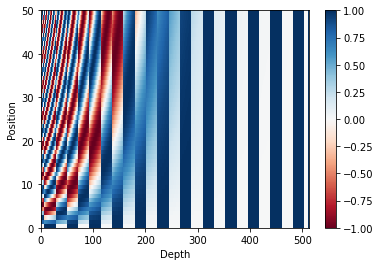

In [160]:
sample_pos_encoding = PositionalEncoding(50, 512)

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

실제 논문에서 제시된 그림에서는 다음과 같이 포지셔널 인코딩을 표현하였습니다.

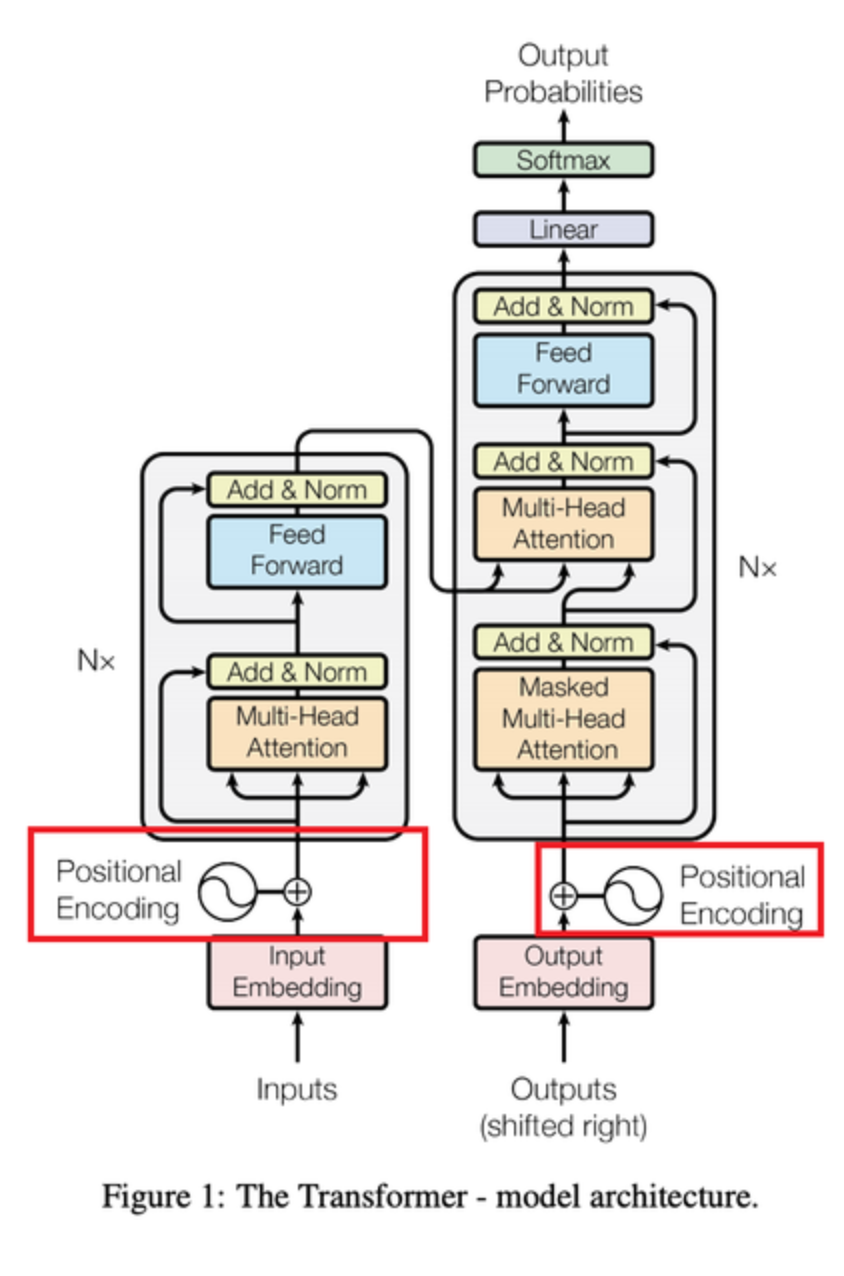

### 4-2. 스케일드 닷 프로덕트 어텐션 구현
---
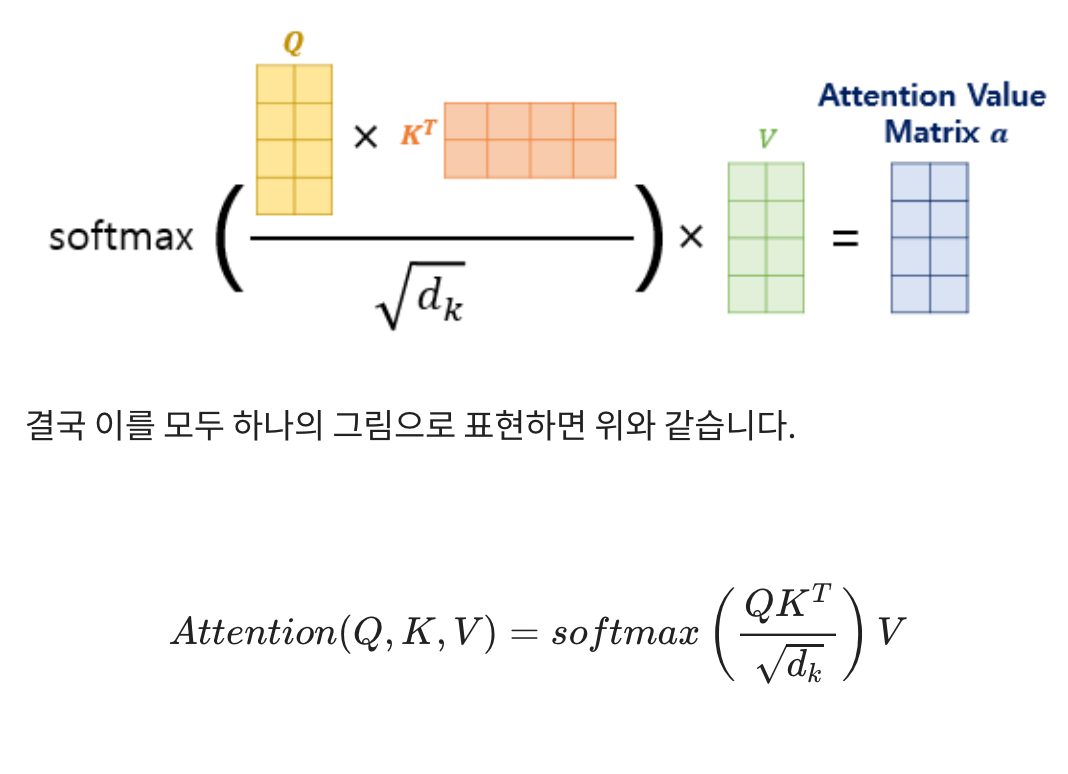

위의 수식은  내적(dot product)을 통해 단어 벡터 간 유사도를 구한 후에, 특정 값을 분모로 나눠주는 방식으로 Q와 K의 유사도를 구하였다고 하여 스케일드 닷 프로덕트 어텐션(Scaled Dot Product Attention) 이라고 합니다.

유사도를 구하는 방법이 스케일드 닷 프로덕트(scaled dot product)였기 때문에 이런 이름이 붙인 것입니다.

In [161]:
# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
  # 어텐션 가중치는 Q와 K의 닷 프로덕트
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # 가중치를 정규화
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # 패딩에 마스크 추가
  if mask is not None:
    logits += (mask * -1e9)

  # softmax적용
  attention_weights = tf.nn.softmax(logits, axis=-1)

  # 최종 어텐션은 가중치와 V의 닷 프로덕트
  output = tf.matmul(attention_weights, value)
  return output

print("슝=3")

슝=3


### 4-3. 멀티-헤드 어텐션 구현
---
병렬로 어텐션을 수행하면 얻을 수 있는 효과는 무엇일까요?

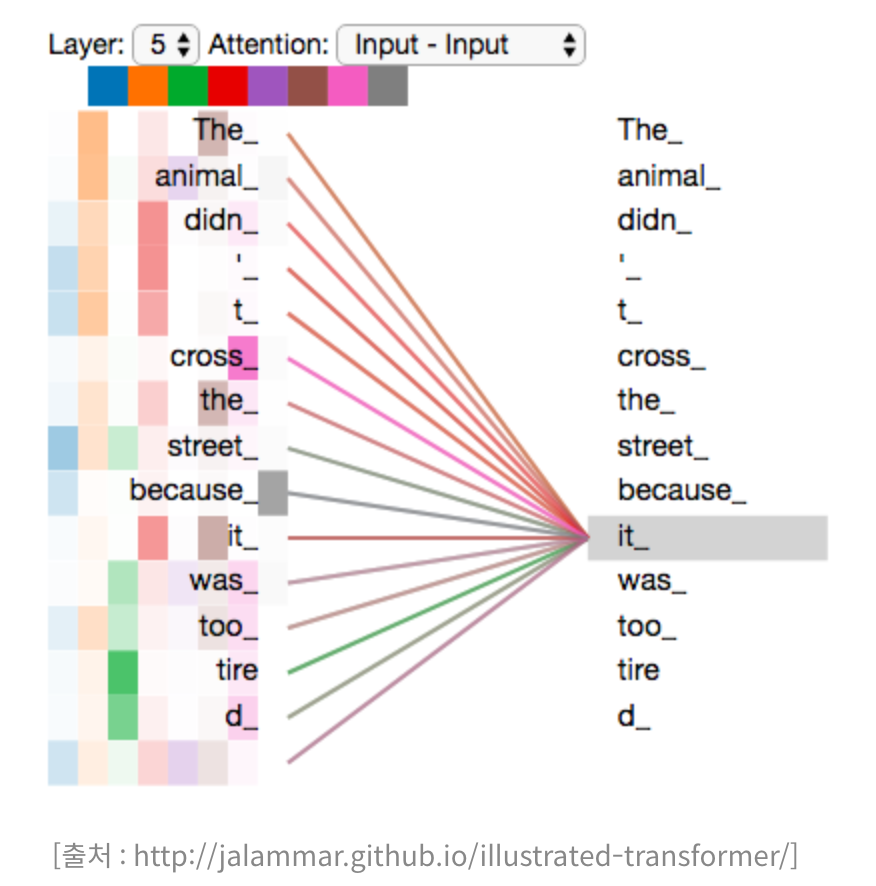

위 그림은 num_heads의 값이 8일 때, 병렬로 수행되는 어텐션이 서로 다른 셀프 어텐션 결과를 얻을 수 있음을 보여줍니다. 다시 말해 8개의 머리는 각각 다른 관점에서 어텐션을 수행하므로 한 번의 어텐션만 수행했다면 놓칠 수도 있던 정보를 캐치할 수 있습니다. 예를 들어 위 그림에서라면 it_이라는 토큰이 animal_과 유사하다고 보는 관점과 street_과 유사하다고 보는 관점이 한꺼번에 모두 표현 가능하다는 뜻입니다.

이와 같이 어텐션을 병렬로 수행하는 것을 멀티 헤드 어텐션이라고 합니다.

In [162]:
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    self.dense = tf.keras.layers.Dense(units=d_model)

  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # Q, K, V에 각각 Dense를 적용합니다
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # 병렬 연산을 위한 머리를 여러 개 만듭니다
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # 스케일드 닷 프로덕트 어텐션 함수
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # 최종 결과에도 Dense를 한 번 더 적용합니다
    outputs = self.dense(concat_attention)

    return outputs
print("슝=3")

슝=3


### 4-4. 패딩 마스킹 구현
---
마스킹(Masking) 이란, 특정 값들을 가려서 실제 연산에 방해가 되지 않도록 하는 기법입니다.

패딩 마스킹은  패딩 토큰(Padding token)을 이용한 방법으로,

문장의 길이가 서로 다를 때, 패딩을 하는 과정을 통해서 모든 문장의 길이를 동일하게 해주는 과정을 거치면서 정해준 길이보다 짧은 문장의 경우에는 숫자 0을 채워서 문장의 길이를 맞춰주는 자연어 처리 전처리 방법입니다.

In [163]:
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, sequence length)
  return mask[:, tf.newaxis, tf.newaxis, :]
print("슝=3")

슝=3


이 함수에 정수 시퀀스를 입력으로 하면, 이 함수는 숫자가 0인 부분을 체크한 벡터를 리턴합니다.

두 개의 정수 시퀀스를 입력으로 해보고, 각각 어떤 결과가 나오는지 보겠습니다.

In [164]:
print(create_padding_mask(tf.constant([[1, 2, 0, 3, 0], [0, 0, 0, 4, 5]])))

tf.Tensor(
[[[[0. 0. 1. 0. 1.]]]


 [[[1. 1. 1. 0. 0.]]]], shape=(2, 1, 1, 5), dtype=float32)


두 정수 시퀀스에 대해서 각각 결과가 출력되는데,

오직 숫자가 0인 위치에서만 숫자 1이 나오고 숫자 0이 아닌 위치에서는 숫자 0인 벡터를 출력합니다.

어텐션 연산 시에 패딩 마스킹을 참고하면 불필요하게 숫자 0을 참고하지 않게 할 수 있습니다.

### 4-5. 룩 어헤드 마스킹 구현
---
트랜스포머의 경우, 전체 문장이 문장 행렬로 들어가기 때문에 위치와 상관없이 모든 단어를 참고해서 다음 단어를 예측할 수 있습니다.

하지만 사실 우리가 원하는 것은 이전 단어들로부터 다음 단어를 예측하는 훈련을 제대로 하는 것입니다.

따라서 이러한 문제를 해결하기 위해 자신보다 다음에 나올 단어를 참고하지 않도록 가리는 기법인 룩 어헤드 마스킹 기법를 사용합니다.

In [165]:
def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x)
  return tf.maximum(look_ahead_mask, padding_mask)
print("슝=3")

슝=3


In [166]:
print(create_look_ahead_mask(tf.constant([[1, 2, 3, 4, 5]])))

tf.Tensor(
[[[[0. 1. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 0. 1. 1.]
   [0. 0. 0. 0. 1.]
   [0. 0. 0. 0. 0.]]]], shape=(1, 1, 5, 5), dtype=float32)


대각선의 형태로 숫자 1이 채워지는 것을 볼 수 있습니다.

그런데 이 마스킹과 패딩 마스킹은 별개이므로, 이 마스킹을 수행할 때 만약에 숫자 0인 단어가 있다면 이 또한 패딩 해야 합니다.

그래서 create_look_ahead_mask() 함수는 내부적으로 앞서 구현한 패딩 마스크 함수도 호출하고 있습니다.

숫자 0이 포함되었을 경우에도 테스트해 봅시다.

In [167]:
print(create_look_ahead_mask(tf.constant([[0, 5, 1, 5, 5]])))

tf.Tensor(
[[[[1. 1. 1. 1. 1.]
   [1. 0. 1. 1. 1.]
   [1. 0. 0. 1. 1.]
   [1. 0. 0. 0. 1.]
   [1. 0. 0. 0. 0.]]]], shape=(1, 1, 5, 5), dtype=float32)


### 4-6. 인코더 층 구현
---

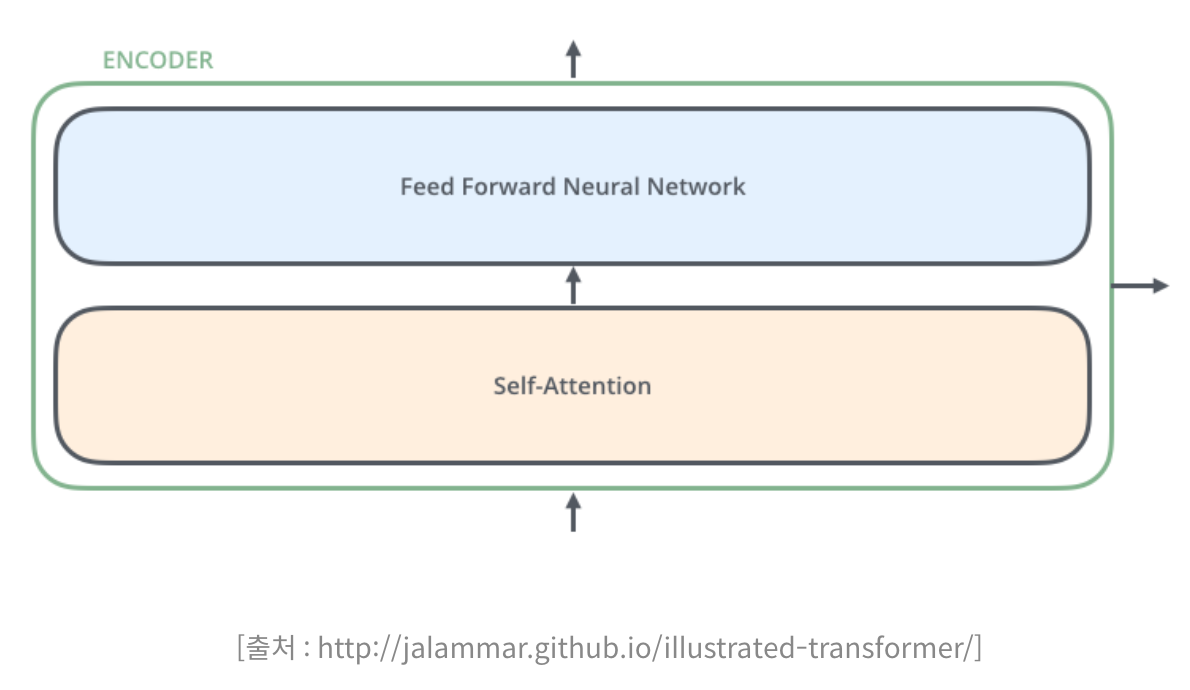

하나의 인코더 층은 크게 총 2개의 서브 층(sublayer)으로 나누어집니다. 바로 셀프 어텐션과 피드 포워드 신경망입니다. 셀프 어텐션은 멀티 헤드 어텐션으로 병렬적으로 이루어집니다.

두 개의 서브 층을 가지는 하나의 인코더 층을 구현하는 함수는 다음과 같습니다. 함수 내부적으로 첫 번째 서브 층과 두 번째 서브 층을 구현하고 있습니다.

In [168]:
# 인코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재합니다.
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })

  # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  # 두 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)
print("슝=3")

슝=3


### 4-7. 인코더 층 쌓아 인코더 구현
---
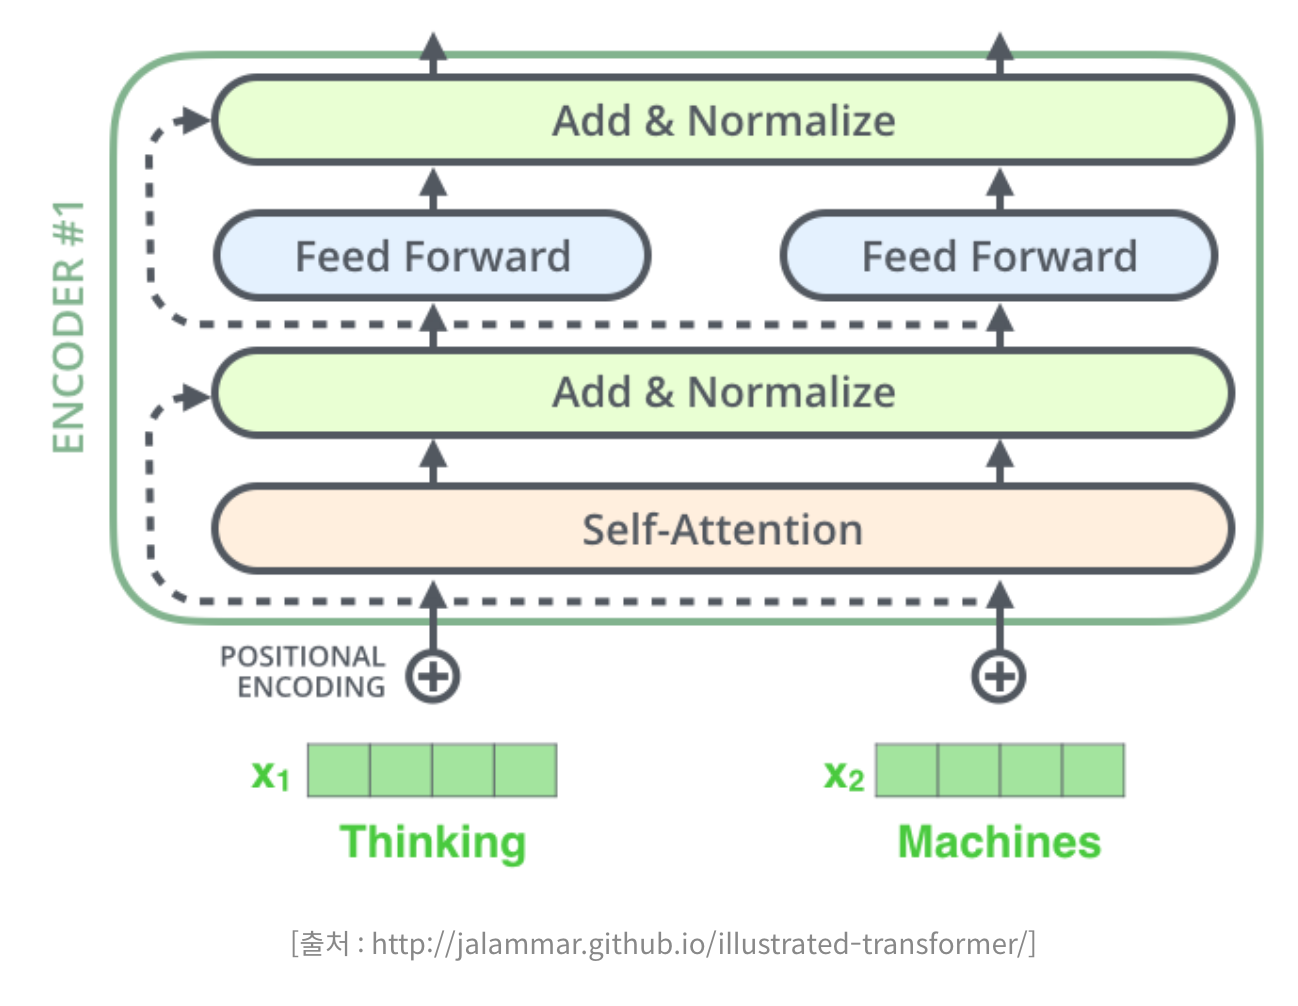

이렇게 구현한 인코더 층을 임베딩 층(Embedding layer) 과 포지셔널 인코딩(Positional Encoding) 을 연결하고, 사용자가 원하는 만큼 인코더 층을 쌓음으로써 트랜스포머의 인코더가 완성됩니다.

인코더와 디코더 내부에서는 각 서브 층 이후에 훈련을 돕는 Layer Normalization이라는 테크닉이 사용되었습니다. 위 그림에서는 Normalize라고 표시된 부분에 해당됩니다.

트랜스포머는 하이퍼파라미터인 num_layers 개수의 인코더 층을 쌓습니다. 논문에서는 총 6개의 인코더 층을 사용하였지만, 실습에서는 학습 시간을 고려하여 그보다 적은 개수를 사용할 예정입니다.

In [169]:
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # num_layers만큼 쌓아올린 인코더의 층.
  for i in range(num_layers):
    outputs = encoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)
print("슝=3")

슝=3


### 4-8. 디코더 층 구현
---
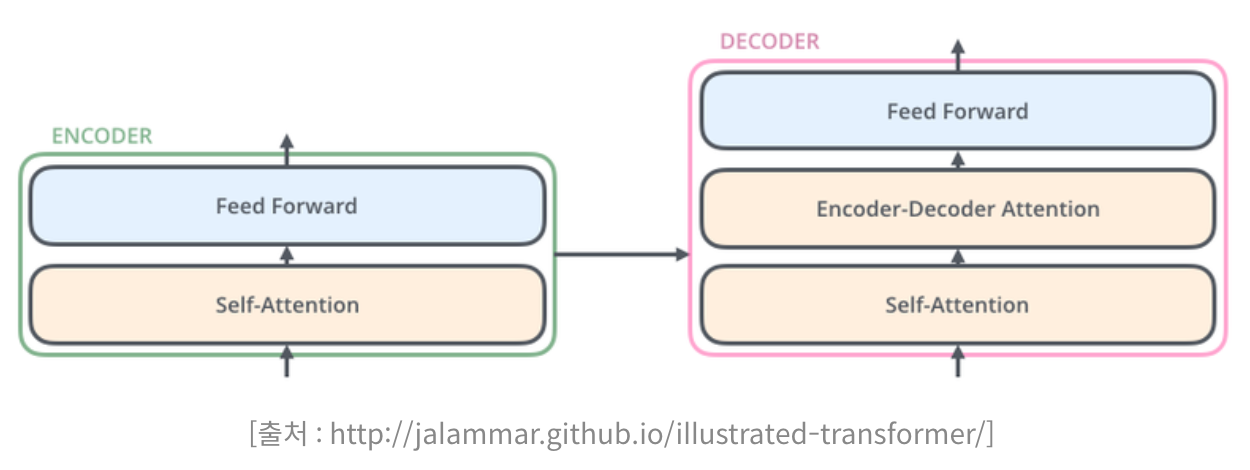

디코더는 인코더와 비슷하지만, 인코더보다 조금 더 복잡합니다.

인코더는 두 개의 서브 층으로 구성되지만, 디코더는 세 개의 서브 층으로 구성된다는 점이 다릅니다.

첫 번째는 셀프 어텐션, 두 번째는 인코더-디코더 어텐션, 세 번째는 피드 포워드 신경망입니다.

인코더-디코더 어텐션은 셀프 어텐션과는 달리, Query가 디코더의 벡터인 반면에 Key와 Value가 인코더의 벡터라는 특징이 있습니다.

이 부분이 인코더가 입력 문장으로부터 정보를 디코더에 전달하는 과정입니다.

인코더의 셀프 어텐션과 마찬가지로 디코더의 셀프 어텐션, 인코더-디코더 어텐션 두 개의 어텐션 모두 스케일드 닷 프로덕트 어텐션을 멀티 헤드 어텐션으로 병렬적으로 수행합니다.

디코더의 세 개의 서브 층을 내부적으로 구현한 디코더의 함수는 다음과 같습니다.

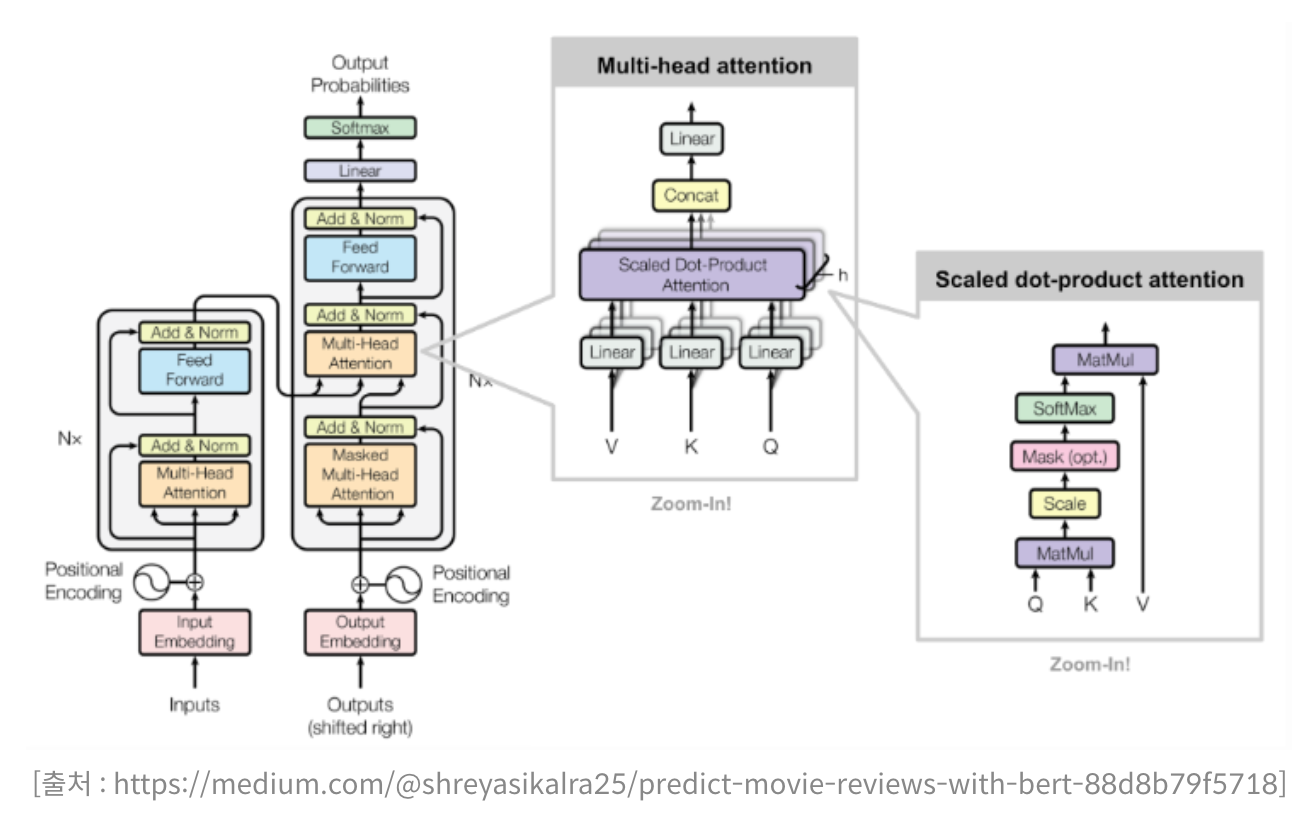

In [170]:
# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })

  # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

  # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
  attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
      })

  # 마스크드 멀티 헤드 어텐션의 결과는
  # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

  # 세 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)
print("슝=3")

슝=3


### 4-9. 디코더 층을 쌓아 디코더 구현
---
이렇게 구현한 디코더의 층은 임베딩 층(Embedding layer) 과 포지셔널 인코딩(Positional Encoding) 을 연결하고, 사용자가 원하는 만큼 디코더 층을 쌓아 트랜스포머의 디코더가 완성됩니다.

인코더와 마찬가지로 num_layers 개수의 디코더 층을 쌓습니다. 논문에서는 총 6개의 디코더 층을 사용하였지만, 실습에서는 학습 시간을 고려하여 그보다 적은 개수를 사용할 예정입니다.

In [171]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')

  # 패딩 마스크
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  
  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  # Dropout이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = decoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)
print("슝=3")

슝=3


이제 인코더 층과 디코더 층을 각각 함수로 구현하였습니다.

이를 하나로 조합하여 트랜스포머 모델을 만들 수 있을 텐데, 우선 그전에 여기서 사용할 챗봇 데이터를 로드하고, 전처리해보겠습니다.

### 4-10. 트랜스포머 함수 정의
---
앞서 사용한 인코더 층 함수와 디코더 층 함수를 사용하여 트랜스포머 함수를 정의합니다.

In [172]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  # 인코더에서 패딩을 위한 마스크
  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

  # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
  # 내부적으로 패딩 마스크도 포함되어져 있습니다.
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)

  # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
  # 디코더에서 패딩을 위한 마스크
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

  # 인코더
  enc_outputs = encoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[inputs, enc_padding_mask])

  # 디코더
  dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  # 완전연결층
  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)
print("슝=3")

슝=3


### 4-11. 모델 생성
---
num_layers, d-Model, units는 전부 사용자가 정할 수 있는 하이퍼파라미터 값입니다.

논문에서 num_layers는 6, d-Model은 512였지만, 빠르고 원활한 훈련을 위해 여기서는 각 하이퍼파라미터를 논문에서보다는 작은 값을 사용합니다.

In [173]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 256)    3147008     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

### 4-12. loss function
---
레이블인 시퀀스에 패딩이 되어 있으므로, loss를 계산할 때 패딩 마스크를 적용해야 합니다.

In [174]:
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)
print("슝=3")

슝=3


### 4-13. 커스텀 된 학습률(Learning rate)
---
딥러닝 모델학습 시 learning rate는 매우 중요한 하이퍼파라미터입니다. 최근에는 모델학습 초기에 learning rate를 급격히 높였다가, 이후 train step이 진행됨에 따라 서서히 낮추어 가면서 안정적으로 수렴하게 하는 고급 기법을 널리 사용하고 있습니다. 이런 방법을 커스텀 학습률 스케줄링(Custom Learning rate Scheduling)이라고 합니다.

논문에 나온 공식을 참고하여 커스텀 학습률 스케줄러를 통한 아담 옵티마이저를 사용합니다. 논문에 나온 공식은 다음과 같습니다.

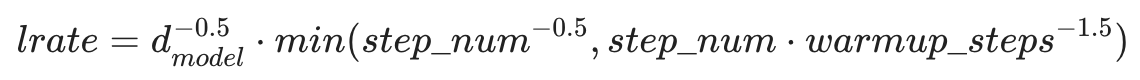

In [175]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)
print("슝=3")

슝=3


그러면 방금 정의한 커스텀 학습률 스케줄링 계획을 시각화해 봅시다.

위에 언급한 수식은 step_num ^−0.5 에 비례하는 부분과 step_num에 비례하는 부분 중 작은 쪽을 택하도록 되어 있습니다.

그래서 학습 초기에는 learning_rate가 step_num에 비례해서 증가하다가 이후로는 감소하는 것을 확인할 수 있습니다.

Text(0.5, 0, 'Train Step')

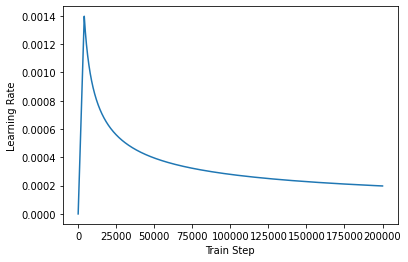

In [176]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

### 4-14. 모델 컴파일
---
손실 함수와 커스텀 된 학습률(learning rate)을 사용하여 모델을 컴파일합니다.

In [177]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])
print("슝=3")

슝=3


### 4-15. 훈련하기
---

In [178]:
EPOCHS = 20
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/20
185/185 [==============================] - 23s 89ms/step - loss: 2.4780 - accuracy: 0.0195
Epoch 2/20
185/185 [==============================] - 17s 89ms/step - loss: 2.0187 - accuracy: 0.0782
Epoch 3/20
185/185 [==============================] - 16s 89ms/step - loss: 1.6847 - accuracy: 0.0814
Epoch 4/20
185/185 [==============================] - 17s 91ms/step - loss: 1.5214 - accuracy: 0.0874
Epoch 5/20
185/185 [==============================] - 17s 89ms/step - loss: 1.4103 - accuracy: 0.0926
Epoch 6/20
185/185 [==============================] - 16s 89ms/step - loss: 1.3418 - accuracy: 0.0987
Epoch 7/20
185/185 [==============================] - 17s 90ms/step - loss: 1.2124 - accuracy: 0.1084
Epoch 8/20
185/185 [==============================] - 17s 89ms/step - loss: 1.1037 - accuracy: 0.1220
Epoch 9/20
185/185 [==============================] - 16s 89ms/step - loss: 0.9656 - accuracy: 0.1360
Epoch 10/20
185/185 [==============================] - 17s 90ms/step - loss: 0.834

## Step 5. 모델 평가하기
---
예측(inference) 단계는 기본적으로 다음과 같은 과정을 거칩니다.

1. 새로운 입력 문장에 대해서는 훈련 때와 동일한 전처리를 거친다.
2. 입력 문장을 토크나이징하고, START_TOKEN과 END_TOKEN을 추가한다.
3. 패딩 마스킹과 룩 어헤드 마스킹을 계산한다.
4. 디코더는 입력 시퀀스로부터 다음 단어를 예측한다.
5. 디코더는 예측된 다음 단어를 기존의 입력 시퀀스에 추가하여 새로운 입력으로 사용한다.
6. END_TOKEN이 예측되거나 문장의 최대 길이에 도달하면 디코더는 동작을 멈춘다.

### 5-1. decoder_inference() 함수 생성
---
위의 과정을 모두 담은 decoder_inference() 함수를 만듭니다.

In [179]:
def decoder_inference(sentence):
  sentence = preprocess_sentence(sentence)

  # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞 뒤로 추가.
  # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
  # 처음에는 예측한 내용이 없으므로 시작 토큰만 별도 저장. ex) 8331
  output_sequence = tf.expand_dims(START_TOKEN, 0)

  # 디코더의 인퍼런스 단계
  for i in range(MAX_LENGTH):
    # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
    predictions = model(inputs=[sentence, output_sequence], training=False)
    predictions = predictions[:, -1:, :]

    # 현재 예측한 단어의 정수
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
    # 이 output_sequence는 다시 디코더의 입력이 됩니다.
    output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

  return tf.squeeze(output_sequence, axis=0)
print("슝=3")

슝=3


### 5-2. sentence_generation() 함수 생성
---
입력 문장에 대해서 decoder_inference() 함수를 호출하여 챗봇의 대답을 얻는 sentence_generation() 함수를 만듭니다.

In [180]:
def sentence_generation(sentence):
  # 입력 문장에 대해서 디코더를 동작시켜 예측된 정수 시퀀스를 리턴받습니다.
  prediction = decoder_inference(sentence)

  # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  print('입력 : {}'.format(sentence))
  print('출력 : {}'.format(predicted_sentence))

  return predicted_sentence
print("슝=3")

슝=3


### 5-3. 챗봇의 대답 확인
---
임의의 문장으로부터 챗봇의 대답을 얻어봅시다.

In [181]:
sentence_generation('오늘 날씨 어때?')

입력 : 오늘 날씨 어때?
출력 : 날씨 어플에 물어보세요 .


'날씨 어플에 물어보세요 .'

In [182]:
sentence_generation('저녁 뭐 먹지?')

입력 : 저녁 뭐 먹지?
출력 : 맛있는 거 드세요 .


'맛있는 거 드세요 .'

In [183]:
sentence_generation("나는 두유를 마실거야!")

입력 : 나는 두유를 마실거야!
출력 : 좋은 우선 관련 서적을 읽어보세요 .


'좋은 우선 관련 서적을 읽어보세요 .'

In [184]:
sentence_generation("보고 싶다")

입력 : 보고 싶다
출력 : 그럴 거라 생각해요 .


'그럴 거라 생각해요 .'

In [185]:
sentence_generation("사랑해")

입력 : 사랑해
출력 : 상대방에게 전해보세요 .


'상대방에게 전해보세요 .'

In [186]:
sentence_generation("소중한 주말이 끝났어...")

입력 : 소중한 주말이 끝났어...
출력 : 잊을 수 있을 거예요 .


'잊을 수 있을 거예요 .'

In [187]:
sentence_generation("나는 사랑에 빠졌었어")

입력 : 나는 사랑에 빠졌었어
출력 : 행복해보여요 .


'행복해보여요 .'

In [188]:
sentence_generation("하지만... 그녀와 헤어졌어")

입력 : 하지만... 그녀와 헤어졌어
출력 : 너무 잘할 거예요 .


'너무 잘할 거예요 .'

In [189]:
sentence_generation("그녀가 보고 싶어.")

입력 : 그녀가 보고 싶어.
출력 : 마음이 허전할 거라 생각해요 .


'마음이 허전할 거라 생각해요 .'

In [190]:
sentence_generation("그녀를 잊을 수 있을까?")

입력 : 그녀를 잊을 수 있을까?
출력 : 힘들긴 하지만 시간이 약이라는 사실을 잊지 말아요 .


'힘들긴 하지만 시간이 약이라는 사실을 잊지 말아요 .'

## Step 6. 루브릭 & 회고
---

### 루브릭

1. 한국어 전처리를 통해 학습 데이터셋을 구축하였다.

- 공백과 특수문자 처리, 토크나이징, 병렬데이터 구축의 과정이 적절히 진행되었다.


2. 트랜스포머 모델을 구현하여 한국어 챗봇 모델 학습을 정상적으로 진행하였다.

- 구현한 트랜스포머 모델이 한국어 병렬 데이터 학습 시 안정적으로 수렴하였다.


3. 한국어 입력문장에 대해 한국어로 답변하는 함수를 구현하였다.

- 한국어 입력문장에 그럴듯한 한국어로 답변을 리턴하였다.

### 회고

- 11/15 월요일 해창님의 논문스터디에서 'attention is all you need'라는 트랜스포머에 대한 논문에 대해서 스터디를 하고, 진행을 한 프로젝트이기에, 나름대로 배경지식이 있는 상태로 프로젝트에 진입했다고 생각했지만, 나의 오만을 판단하기에 너무나도 적절했던 프로젝트가 아니었나 싶다.

- 트랜스포머에 대한 구조에 대한 이해도 부족의 문제인지... 인코더 & 디코더의 병렬화 부터 트랜스포머 함수에 대한 코드까지 제대로 이해를 하고 진행하지 못 한 것 같단는 생각이 프로젝트를 마치는 이 순간까지 아쉬움을 남긴다.

- 일단 그럼에도, 노드에서 진행한 순서에 따라 프로젝트를 진행하였으며, 그에 따른 한국어 데이터로 만들어진 챗봇의 결과를 보면 나름대로 문장을 생성하는 것을 보고 신기하다는 생각을 하였다.

- 물론 현재로서는, 내가 적은 코드에 대한 이해에 부족으로 코드로 부터 나오는 결과값을 보며 '이 코드를 통해서 이러한 결과를 내는 구나!' 라는 역추론의 방식으로 학습 중이지만, 내가 생각한 흐름에 맞춰서 코드를 작성해내고 내가 원하는 결과물을 만들어내는 사람이 되어보고 싶다. 

### 이번 프로젝트의 원활한 진행을 위한 레퍼런스 링크

- https://wikidocs.net/31379
- https://www.youtube.com/watch?v=YAgjfMR9R_M&list=PL5-TkQAfAZFbzxjBHtzdVCWE0Zbhomg7r&index=14
- https://nlpinkorean.github.io/illustrated-transformer/
- https://velog.io/@cha-suyeon/%ED%8A%B8%EB%9E%9C%EC%8A%A4%ED%8F%AC%EB%A8%B8%EC%99%80-%EC%9D%B8%EC%BD%94%EB%8D%94-%EB%94%94%EC%BD%94%EB%8D%94